# Multiple Linear Regression for Robot Calibration

For this example we will illustrate the use of multiple linear regression for calibrating robot control. 

The robot data is taken generously from the TU Dortmund's [Multiple Link Robot Arms Project](http://www.rst.e-technik.tu-dortmund.de/cms/en/research/robotics/TUDOR_engl/index.html).  As part of the project, they have created an excellent public dataset: [MERIt](http://www.rst.e-technik.tu-dortmund.de/cms/en/research/robotics/TUDOR_engl/index.html#h3MERIt) -- A Multi-Elastic-Link Robot Identification Dataset that can be used for understanding robot dynamics.  The data is from a three link robot:

<img src="http://www.rst.e-technik.tu-dortmund.de/cms/Medienpool/redaktionelleBilder/Forschung/Schwerpunkte/TUDOR_engl/TUDORBild.png" height="200" width="200">


We will focus on predicting the electric current draw into one of the joints as a function of the robot motion.  Such models are essential in predicting the overall robot power consumption.  Several other models could also be used.

## Load CSV Data
First, import the modules we will need.

In [5]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline

The full MERIt dataset can be obtained from the [MERIt site](http://www.rst.e-technik.tu-dortmund.de/cms/en/research/robotics/TUDOR_engl/index.html#h3MERIt).  But, this dataset is large.  Included in this repository are two of the ten experiments.  Each experiments corresonds to 80 seconds of recorded motion.  We will use the following files:
* [exp1.csv](./exp1.csv) for training
* [exp2.csv](./exp2.csv) for test

Below, I have supplied the column headers in the `names` array, loaded the data into a panda dataframe, and inspected the first 6 samples from the data. Note that we are setting the time column as the index column through index_col=0.

In [6]:
names =[
    't',                                  # Time (secs)
    'q1', 'q2', 'q3',                     # Joint angle   (rads)
    'dq1', 'dq2', 'dq3',                  # Joint velocity (rads/sec)
    'I1', 'I2', 'I3',                     # Motor current (A)
    'eps21', 'eps22', 'eps31', 'eps32',   # Strain gauge measurements ($\mu$m /m )
    'ddq1', 'ddq2', 'ddq3'                # Joint accelerations (rad/sec^2)
]

df = pd.read_csv('exp1.txt', header=None,index_col=0,names=names,na_values='?')

print(df.head(6))

            q1      q2      q3           dq1            dq2           dq3  \
t                                                                           
0.00 -0.000007  2.4958 -1.1345 -7.882100e-21 -4.940656e-321  3.913100e-29   
0.01 -0.000007  2.4958 -1.1345 -2.258200e-21 -4.940656e-321  2.626200e-31   
0.02 -0.000007  2.4958 -1.1345 -6.469800e-22 -4.940656e-321  1.762500e-33   
0.03 -0.000007  2.4958 -1.1345 -1.853600e-22 -4.940656e-321  1.182800e-35   
0.04 -0.000007  2.4958 -1.1345 -5.310600e-23 -4.940656e-321 -5.270900e-03   
0.05 -0.000007  2.4958 -1.1345 -1.521500e-23 -4.940656e-321  3.252600e-04   

            I1       I2       I3   eps21   eps22   eps31    eps32  \
t                                                                   
0.00 -0.081623 -0.40812 -0.30609 -269.25 -113.20  3.5918  1.57860   
0.01 -0.037411 -0.37241 -0.26698 -270.91 -116.05  1.4585 -1.73980   
0.02 -0.066319 -0.40302 -0.31459 -269.25 -112.97  3.5918  0.86753   
0.03 -0.068020 -0.43703 -0.28398 -269.

## Handle and Visualize the Data 

From dataframe, assign columns to variables to handle the Data and get familiar with it. We extract the time indices into a vector `t` and extract `I2`, the current into the second joint.  Place the current in a vector `y` and plot `y` vs. `t`. 

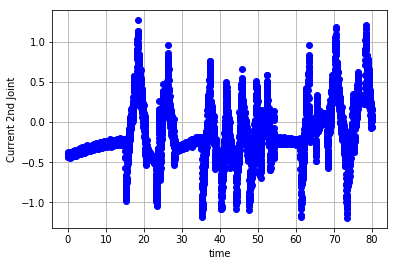

In [7]:
#------------Plot Current 2nd Joint -----------
y = np.array(df['I2'])
t = np.array(df.index.values)
plt.plot(t,y,'ob')
plt.xlabel('time')
plt.ylabel('Current 2nd Joint')
plt.grid(True)

Use all the samples from the exp1.csv dataset to create the training data:
* `ytrain`:  A vector of all the samples from the `I2` column
* `Xtrain`:  A matrix of the data with the columns:  `['q2','dq2','eps21', 'eps22', 'eps31', 'eps32','ddq2']`

In [14]:
#-----------Define output and labels(attributes) for training data -----
ytrain = y
Xtrain = np.array(df[['q2','dq2','eps21', 'eps22', 'eps31', 'eps32','ddq2']])

## Fit a Linear Model
Use the `sklearn.linear_model` module to create a `LinearRegression` class `regr`. Then train (fit) the model on the training data

In [9]:
regr = linear_model.LinearRegression()
regr.fit(Xtrain,ytrain)
#print('PRINT COEFFICIENTS = ',regr.coef)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

<br>
Using the trained model, compute, `y_tr_pred`, the predicted current.  Plot `y_tr_pred` vs. time `t`.  On the same plot, plot the actual current `ytrain` vs. time `t`.  Create a legend for the plot.

RSS per sample = 0.095833


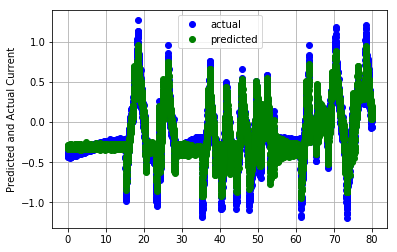

In [20]:
y_tr_pred = regr.predict(Xtrain)
RSS_tr = np.mean((y_tr_pred-ytrain)**2)/(np.std(ytrain)**2)
print("RSS per sample = {0:f}".format(RSS_tr))

plt.plot(t, ytrain,'ob', t, y_tr_pred,'og')
plt.ylabel('Predicted and Actual Current')
plt.grid(True)
plt.legend(["actual","predicted"])

## Measure the Fit on an Indepdent Dataset

Up to now, we have only tested the model on the same data on which it was trained.  In general, we need to test model on independent data not used in the training.  For this purpose, load the data in `exp2.csv`. We Compute the regression predicted values on this data and plot the predicted and actual values over time.

RSS per sample = 0.126780


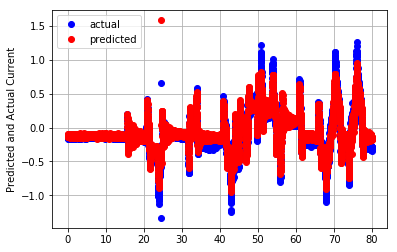

In [19]:
df2 = pd.read_csv('exp2.txt', header=None,index_col=0,names=names,na_values='?')

ytest = np.array(df2['I2'])
Xtest = np.array(df2[['q2','dq2','eps21', 'eps22', 'eps31', 'eps32','ddq2']])
t2 = np.array(df2.index.values)
y_test_pred = regr.predict(Xtest)
RSS_test = np.mean((y_test_pred-ytest)**2)/(np.std(ytest)**2)
print("RSS per sample = {0:f}".format(RSS_test))

plt.figure(2)
plt.plot(t2,ytest,'ob',t2,y_test_pred,'or')
plt.ylabel('Predicted and Actual Current')
plt.grid(True)
plt.legend(["actual","predicted"])
#plt.show()